In [2]:
import json 
import pandas as pd
import numpy as np
from tqdm import tqdm

In [40]:
# triples with original refs
# 30 dropout runs    
# each triple has mean and std score

#zeus

# f = open ('/media/hdd1/glushkovato/comet/segments.json', "r") 
# f = open ('/media/hdd1/glushkovato/comet/segments-fulltrain-dropout-01.json', "r") 
# f = open('/media/hdd1/glushkovato/comet/segments-3hqref.json', 'r')
# f = open('/media/hdd1/glushkovato/comet/segments-3hqref-fulltrain-dropout-01.json', 'r')
# f = open('/media/hdd1/glushkovato/comet/segments-lw-dropout-01.json', 'r')

f = open('/media/hdd1/glushkovato/comet/segments-fulltrain-90dpruns.json', 'r')
# f = open('/media/hdd1/glushkovato/comet/segments-fulltrain-60dpruns.json', 'r')
# f = open('/media/hdd1/glushkovato/comet/segments-hqp-hqr-fulltrain.json', 'r')

# f = open('/media/hdd1/glushkovato/comet/segments-ar-arp-wmtp-fulltrain.json', 'r')
# f = open('/media/hdd1/glushkovato/comet/segments-orig-ar-arp-wmtp-fulltrain.json', 'r')



# - - - - - - - - - - - - - - - - 
# f = open ('/media/hdd1/glushkovato/comet/test-out.json', "r") 
# f = open ('/media/hdd1/glushkovato/comet/segments-arp-ref-norm.json', "r") 

data = json.loads(f.read()) 
f.close() 

In [ ]:
# 7 and 9       
# segments-lw-dropout-01.json     
# segments-fulltrain-dropout-01.json    

# f1 = open('/media/hdd1/glushkovato/comet/segments-lw-dropout-01.json', 'r')
# f2 = open ('/media/hdd1/glushkovato/comet/segments-fulltrain-dropout-01.json', "r") 


# 11 and 16     
# segments-fulltrain-90dpruns.json      
# segments-ar-arp-wmtp-fulltrain.json

# f1 = open('/media/hdd1/glushkovato/comet/segments-fulltrain-90dpruns.json', 'r')
# f2 = open('/media/hdd1/glushkovato/comet/segments-ar-arp-wmtp-fulltrain.json', 'r')

data = json.loads(f.read()) 
f.close() 

In [41]:
data[0]

{'src': "Welsh AMs worried about 'looking like muppets'",
 'mt': 'Waliser AMs besorgt darüber, „wie Muppets auszusehen“',
 'ref': 'Walisische Ageordnete sorgen sich "wie Dödel auszusehen"',
 'predicted_score_mean': -0.13374045720944802,
 'predicted_score_std': 0.21109000179675966}

In [42]:
# data[0]

In [43]:
lines = []
for i in data:
    lines.append([i['src'], i['mt'], i['ref'], i['predicted_score_mean'], i['predicted_score_std']])

In [47]:
df = pd.DataFrame(data=np.array(lines), 
                  columns=['src','mt', 'ref', 'predicted_score_mean','predicted_score_std'])

# df.iloc[:6]

df = df.iloc[::1, :]
df.iloc[:3]

,src,mt,ref,predicted_score_mean,predicted_score_std
0,Welsh AMs worried about 'looking like muppets',"Waliser AMs besorgt darüber, „wie Muppets ausz...","Walisische Ageordnete sorgen sich ""wie Dödel a...",-0.13374045720944802,0.21109000179675966
1,There is consternation among some AMs at a sug...,Bei einigen AMs herrscht Bestürzung über einen...,Es herrscht Bestürzung unter einigen Mitgliede...,0.25846957800288994,0.11855216345599451
2,It has arisen because of plans to change the n...,"Sie ist aufgrund von Plänen entstanden, den Na...","Der Grund dafür waren Pläne, den Namen der Nat...",0.24677283981194098,0.12374979385480753


In [48]:
df.shape

(1997, 5)

In [49]:
df['predicted_score_std'].min()

'0.030642683358589978'

In [50]:
df['predicted_score_std'].max()

'0.4999544656906167'

In [51]:
da_scores = pd.read_csv('/media/hdd1/glushkovato/comet/COMET_uncertainty/data/da_scores_combined_ref.csv')
da_scores.iloc[:3]

,src,ref,extra_ref,Facebook_FAIR.6862,SID,raw_score,z_score,z_score_norm,raw_score_norm,annotators
0,Welsh AMs worried about 'looking like muppets',"Walisische Ageordnete sorgen sich ""wie Dödel a...","Walisische Abgeordnete befürchten als ,Idioten...","Waliser AMs besorgt darüber, „wie Muppets ausz...",0,NaN,NaN,NaN,NaN,NaN
1,There is consternation among some AMs at a sug...,Es herrscht Bestürzung unter einigen Mitgliede...,Bei einigen AMs herrscht Fassungslosigkeit übe...,Bei einigen AMs herrscht Bestürzung über einen...,1,96.5,0.696150,0.591311,0.410417,2.0
2,It has arisen because of plans to change the n...,"Der Grund dafür waren Pläne, den Namen der Nat...","Es kam wegen Plänen auf, den Namen der Versamm...","Sie ist aufgrund von Plänen entstanden, den Na...",2,68.0,-0.652806,-1.690535,-1.485173,1.0


In [52]:
df['z_score'] = da_scores['z_score'].tolist()
df['z_score_norm'] = da_scores['z_score_norm'].tolist()

cols = ['predicted_score_mean', 'predicted_score_std', 'z_score', 'z_score_norm']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [53]:
df.head()

,src,mt,ref,predicted_score_mean,predicted_score_std,z_score,z_score_norm
0,Welsh AMs worried about 'looking like muppets',"Waliser AMs besorgt darüber, „wie Muppets ausz...","Walisische Ageordnete sorgen sich ""wie Dödel a...",-0.133740,0.211090,NaN,NaN
1,There is consternation among some AMs at a sug...,Bei einigen AMs herrscht Bestürzung über einen...,Es herrscht Bestürzung unter einigen Mitgliede...,0.258470,0.118552,0.696150,0.591311
2,It has arisen because of plans to change the n...,"Sie ist aufgrund von Plänen entstanden, den Na...","Der Grund dafür waren Pläne, den Namen der Nat...",0.246773,0.123750,-0.652806,-1.690535
3,AMs across the political spectrum are worried ...,AMs im gesamten politischen Spektrum sind beso...,Mitglieder aller Parteien der Nationalversamml...,0.508610,0.093468,-0.013827,-0.609661
4,"One Labour AM said his group was concerned ""it...","Ein Labour AM sagte, seine Gruppe sei besorgt,...","Ein Labour-Abgeordneter sagte, dass seine Grup...",0.028673,0.160063,0.246498,-0.169304


In [54]:
df.shape

(1997, 7)

In [55]:
df = df.dropna()
df.shape

(1744, 7)

In [56]:
df['q-mu'] = np.abs(df['z_score'] - df['predicted_score_mean'])

In [57]:
df.head()

,src,mt,ref,predicted_score_mean,predicted_score_std,z_score,z_score_norm,q-mu
1,There is consternation among some AMs at a sug...,Bei einigen AMs herrscht Bestürzung über einen...,Es herrscht Bestürzung unter einigen Mitgliede...,0.258470,0.118552,0.696150,0.591311,0.437680
2,It has arisen because of plans to change the n...,"Sie ist aufgrund von Plänen entstanden, den Na...","Der Grund dafür waren Pläne, den Namen der Nat...",0.246773,0.123750,-0.652806,-1.690535,0.899579
3,AMs across the political spectrum are worried ...,AMs im gesamten politischen Spektrum sind beso...,Mitglieder aller Parteien der Nationalversamml...,0.508610,0.093468,-0.013827,-0.609661,0.522438
4,"One Labour AM said his group was concerned ""it...","Ein Labour AM sagte, seine Gruppe sei besorgt,...","Ein Labour-Abgeordneter sagte, dass seine Grup...",0.028673,0.160063,0.246498,-0.169304,0.217825
5,For readers outside of Wales: In Welsh twp mea...,Für Leser außerhalb von Wales: Auf Walisisch b...,Hinweis für den Leser: „twp“ im Walisischen be...,-0.199527,0.190064,0.719816,0.631343,0.919343


In [58]:
z_scores = df['z_score'].tolist()
z_scores_norm = df['z_score_norm'].tolist()
mean_vals = df['predicted_score_mean'].tolist()
std_vals = df['predicted_score_std'].tolist()

In [59]:
print('min std: ', round(min(std_vals), 6))
print('max std: ', round(max(std_vals), 6))

min std:  0.030774
max std:  0.499954


## data plots

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Math, Latex
from IPython.core.display import Image
import seaborn as sns
sns.set(color_codes=True)

sns.set(rc={'figure.figsize':(10,5)}) # seaborn plot sizes

### test example

In [61]:
from scipy.stats import norm

# data_normal = norm.rvs(size=10000,loc=0,scale=1) # random numbers from N(0,1)

In [62]:
# ax = sns.distplot(sorted(data_normal),
#                   bins=100,
#                   kde=True,
#                   color='skyblue',
#                   hist_kws={"linewidth": 15,'alpha':1})
# ax.set(xlabel='Normal Distribution', ylabel='Frequency')

### our data

mean values for each triple

/media/hdd1/glushkovato/comet/py37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'mean_vals distribution'), Text(0, 0.5, 'Frequency')]

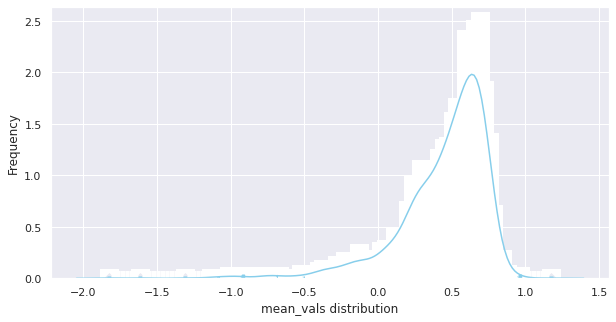

In [63]:
ax = sns.distplot(mean_vals,
                  bins=100,
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})

ax.set(xlabel='mean_vals distribution', ylabel='Frequency')

/media/hdd1/glushkovato/comet/py37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'z_scores distribution'), Text(0, 0.5, 'Frequency')]

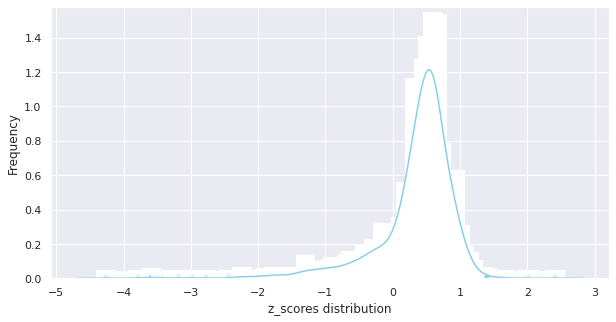

In [64]:
ax = sns.distplot(z_scores,
                  bins=100,
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})

ax.set(xlabel='z_scores distribution', ylabel='Frequency')

In [65]:
tmp_df = df[['predicted_score_mean', 'predicted_score_std', 'z_score', 'q-mu']]
tmp_df.columns = ['comet_mean', 'comet_std', 'da_score', '|da_score-comet_mean|']
tmp_df.head()

,comet_mean,comet_std,da_score,|da_score-comet_mean|
1,0.258470,0.118552,0.696150,0.437680
2,0.246773,0.123750,-0.652806,0.899579
3,0.508610,0.093468,-0.013827,0.522438
4,0.028673,0.160063,0.246498,0.217825
5,-0.199527,0.190064,0.719816,0.919343


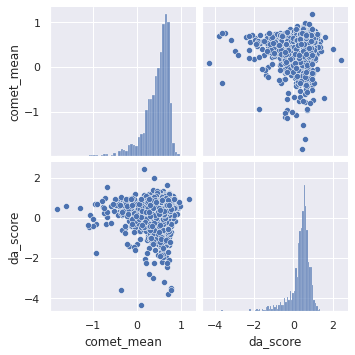

In [66]:
g = sns.pairplot(tmp_df[['comet_mean', 'da_score']])

In [67]:
tmp_df['comet_mean'].mean() 

0.44853367160711555

In [68]:
tmp_df['da_score'].mean()

0.34679193216427295

In [69]:
tmp_df['comet_mean'].min()

-1.8424169447686936

In [70]:
tmp_df['comet_mean'].max()

1.1910192688306174

In [71]:
tmp_df['da_score'].min()

-4.30188188115954

In [72]:
tmp_df['da_score'].max()

2.43796983116887

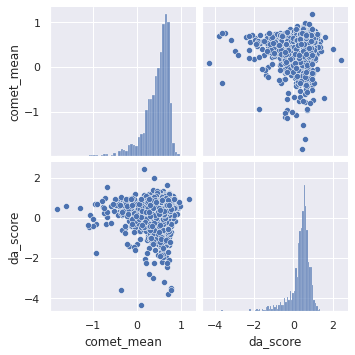

In [73]:
sns.pairplot(tmp_df[['comet_mean', 'da_score']])

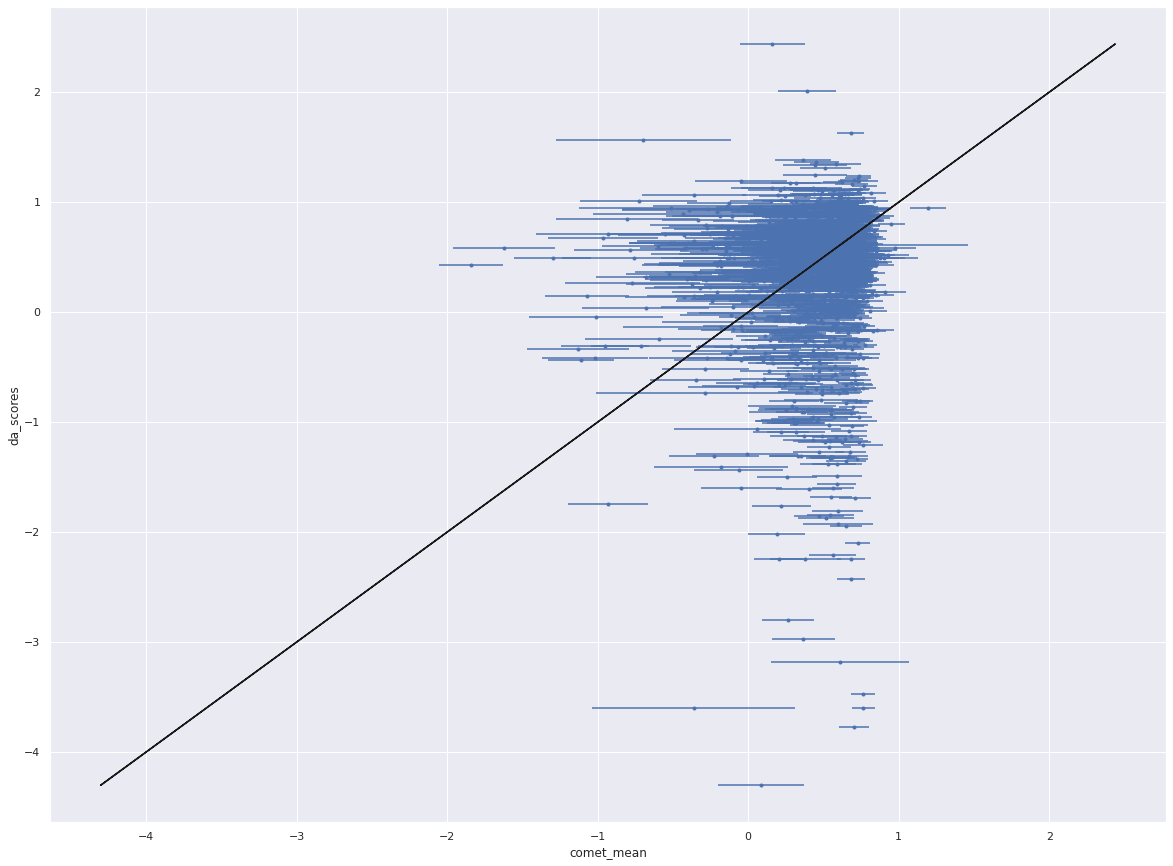

In [74]:
plt.figure(figsize=(20,15))

x = np.array(tmp_df['comet_mean'].tolist())
y = np.array(tmp_df['da_score'].tolist())
xerr = 2*np.array(tmp_df['comet_std'].tolist())

plt.plot(x,y,'b.') # x vs y
# plt.plot(x,x,'k-') # identity line
plt.plot(y,y,'k-') # identity line
# plt.errorbar(x, y, yaerr, marker='s', mfc='red', mec='green', ms=20, mew=4)
plt.errorbar(x, y, xerr=xerr, fmt='none')


# plt.xlim(-1,2)
# plt.ylim(-1,2)

plt.xlabel('comet_mean')
plt.ylabel('da_scores')
plt.show()

In [75]:
xerr.min()

0.0615484896230746

In [76]:
xerr.max()

0.9999089313812334

In [138]:
# comet_mean
min_thres = -0.5
max_thres = 0.8

# da_score
min_thres_da = -0.5
max_thres_da = 1

In [139]:
# tmp_df[tmp_df.comet_mean <= 0].shape
print('negative')
negative_std = tmp_df[tmp_df.comet_mean <= min_thres].comet_std
print('min: ', tmp_df[tmp_df.comet_mean <= min_thres].comet_std.min())
print('max: ', tmp_df[tmp_df.comet_mean <= min_thres].comet_std.max())
print('avg: ', tmp_df[tmp_df.comet_mean <= min_thres].comet_std.mean())
print()

# tmp_df[tmp_df.comet_mean >= 1].shape
print('positive')
positive_std = tmp_df[tmp_df.comet_mean >= max_thres].comet_std
print('min: ', tmp_df[tmp_df.comet_mean >= max_thres].comet_std.min())
print('max: ', tmp_df[tmp_df.comet_mean >= max_thres].comet_std.max())
print('avg: ', tmp_df[tmp_df.comet_mean >= max_thres].comet_std.mean())
print()

a = tmp_df[tmp_df.comet_mean > min_thres]
a[a.comet_mean < 1].shape
# tmp_df[[tmp_df.comet_mean > 0 and tmp_df.comet_mean < 1]].shape

print('neutral')
neutral_std = a[a.comet_mean < max_thres].comet_std
print('min: ', a[a.comet_mean < max_thres].comet_std.min())
print('max: ', a[a.comet_mean < max_thres].comet_std.max())
print('avg: ', a[a.comet_mean < max_thres].comet_std.mean())
print()

negative
min:  0.112062968837664
max:  1.075268955925214
avg:  0.35430123688133064

positive
min:  0.1248502702894144
max:  0.3822559624354397
avg:  0.18988001886791903

neutral
min:  0.0428098299700219
max:  1.2063081167700422
avg:  0.20314312326617673



[Text(0.5, 0, 'std value')]

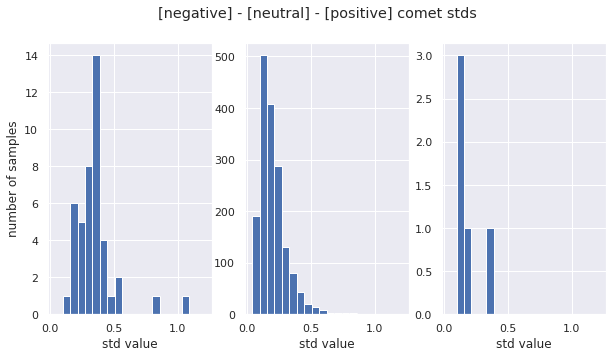

In [140]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('[negative] - [neutral] - [positive] comet stds')
ax1.hist(negative_std, range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
ax2.hist(neutral_std, range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
ax3.hist(positive_std, range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)

ax1.set(xlabel='std value', ylabel='number of samples')
ax2.set(xlabel='std value')
ax3.set(xlabel='std value')

In [141]:
print('negative')
# tmp_df[tmp_df.comet_mean <= 0.3].shape
negative_std_da = tmp_df[tmp_df.da_score <= min_thres_da].comet_std
print('min: ', tmp_df[tmp_df.da_score <= min_thres_da].comet_std.min())
print('max: ', tmp_df[tmp_df.da_score <= min_thres_da].comet_std.max())
print('avg: ', tmp_df[tmp_df.da_score <= min_thres_da].comet_std.mean())
print()

print('positive')
# tmp_df[tmp_df.comet_mean >= 1].shape
positive_std_da = tmp_df[tmp_df.da_score >= max_thres_da].comet_std
print('min: ', tmp_df[tmp_df.da_score >= max_thres_da].comet_std.min())
print('max: ', tmp_df[tmp_df.da_score >= max_thres_da].comet_std.max())
print('avg: ', tmp_df[tmp_df.da_score >= max_thres_da].comet_std.mean())
print()

a = tmp_df[tmp_df.da_score > min_thres_da]
a[a.da_score < 1].shape
# tmp_df[[tmp_df.comet_mean > 0 and tmp_df.comet_mean < 1]].shape
print('neutral')
neutral_std_da = a[a.da_score < max_thres_da].comet_std
print('min: ', a[a.da_score < max_thres_da].comet_std.min())
print('max: ', a[a.da_score < max_thres_da].comet_std.max())
print('mean: ', a[a.da_score < max_thres_da].comet_std.mean())
print()

negative
min:  0.0683453568012779
max:  0.7352526655941375
avg:  0.2271600695413019

positive
min:  0.0438325919121454
max:  0.3718185267089771
avg:  0.16443001983364108

neutral
min:  0.0428098299700219
max:  1.2063081167700422
mean:  0.2067169293291554



[Text(0.5, 0, 'std value')]

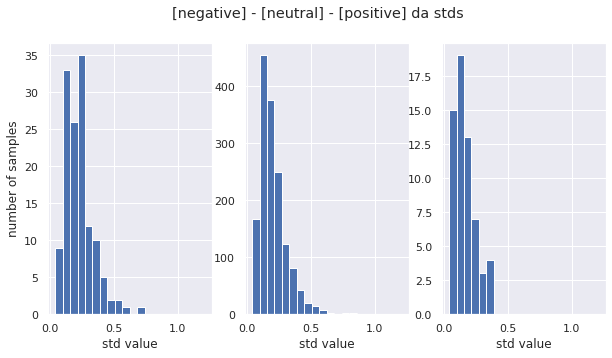

In [142]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('[negative] - [neutral] - [positive] da stds')
ax1.hist(negative_std_da, range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
ax2.hist(neutral_std_da, range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
ax3.hist(positive_std_da, range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)

ax1.set(xlabel='std value', ylabel='number of samples')
ax2.set(xlabel='std value')
ax3.set(xlabel='std value')


In [143]:
comet_splits = [negative_std, neutral_std, positive_std]
da_splits = [negative_std_da, neutral_std_da, positive_std_da]

comet_splits_names = ['negative_std', 'neutral_std', 'positive_std']
da_splits_names = ['negative_std_da', 'neutral_std_da', 'positive_std_da']

In [144]:
pairs = [(c, da) for c in comet_splits for da in da_splits]
pairs_names = [(c, da) for c in comet_splits_names for da in da_splits_names]

intersecs = []

for pair, name in zip(pairs, pairs_names):
    print(name)
    common_idx = pair[0].index.intersection(pair[1].index)
    common = pair[0].loc[common_idx]
    print('min: ', common.min())
    print('max: ', common.max())
    print('mean: ', common.mean())
    print('# samples: ', len(common))
    intersecs.append(common)
#     plt.hist(common, range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
#     plt.show()
    print()

# zip(pairs, pairs_names)

('negative_std', 'negative_std_da')
min:  0.3474811531859463
max:  0.4025297781832066
mean:  0.3787652336837676
# samples:  4

('negative_std', 'neutral_std_da')
min:  0.112062968837664
max:  1.075268955925214
mean:  0.3511009527348897
# samples:  37

('negative_std', 'positive_std_da')
min:  0.3599061577902868
max:  0.3692508421809434
mean:  0.3645784999856151
# samples:  2

('neutral_std', 'negative_std_da')
min:  0.0683453568012779
max:  0.7352526655941375
mean:  0.22256597365819691
# samples:  132

('neutral_std', 'neutral_std_da')
min:  0.0428098299700219
max:  1.2063081167700422
mean:  0.2032232254662278
# samples:  1505

('neutral_std', 'positive_std_da')
min:  0.0438325919121454
max:  0.3718185267089771
mean:  0.15764532559120129
# samples:  59

('positive_std', 'negative_std_da')
min:  nan
max:  nan
mean:  nan
# samples:  0

('positive_std', 'neutral_std_da')
min:  0.1248502702894144
max:  0.3822559624354397
mean:  0.18988001886791903
# samples:  5

('positive_std', 'positive_

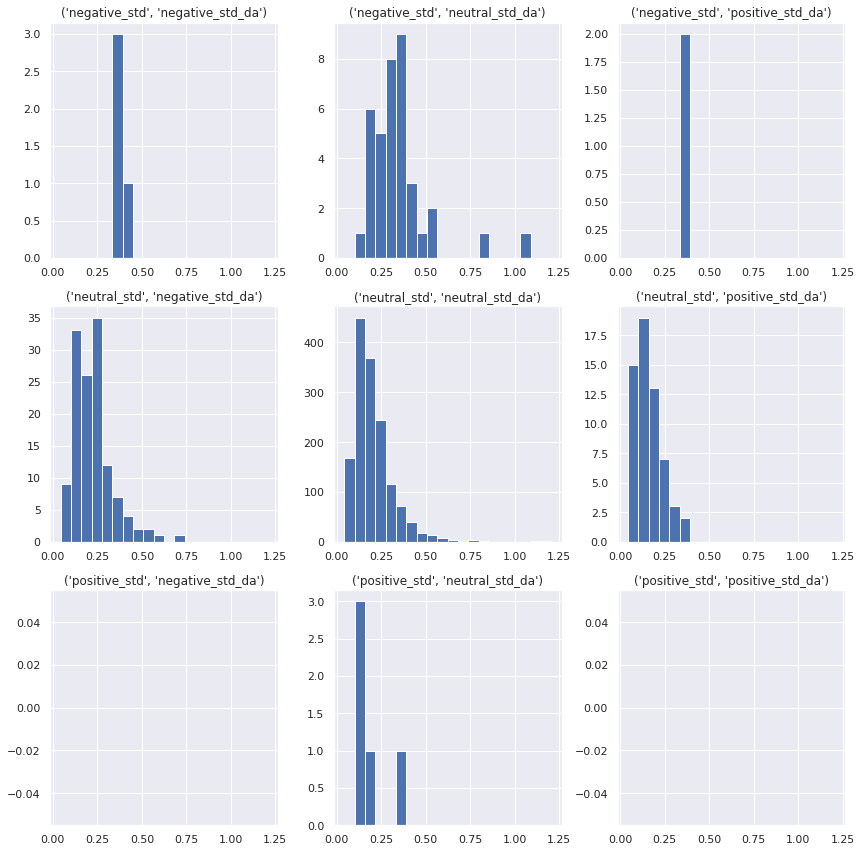

In [145]:
fig, axs = plt.subplots(3, 3, figsize=(12,12))
# fig.suptitle('[negative] - [neutral] - [positive] intersections')

axs[0,0].hist(intersecs[0], range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
axs[0,0].set_title(pairs_names[0])
axs[0,1].hist(intersecs[1], range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
axs[0,1].set_title(pairs_names[1])
axs[0,2].hist(intersecs[2], range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
axs[0,2].set_title(pairs_names[2])

axs[1,0].hist(intersecs[3], range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
axs[1,0].set_title(pairs_names[3])
axs[1,1].hist(intersecs[4], range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
axs[1,1].set_title(pairs_names[4])
axs[1,2].hist(intersecs[5], range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
axs[1,2].set_title(pairs_names[5])

axs[2,0].hist(intersecs[6], range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
axs[2,0].set_title(pairs_names[6])
axs[2,1].hist(intersecs[7], range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
axs[2,1].set_title(pairs_names[7])
axs[2,2].hist(intersecs[8], range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
axs[2,2].set_title(pairs_names[8])

fig.tight_layout()
# ax1.set(xlabel='std value', ylabel='number of samples')
# ax2.set(xlabel='std value')
# ax3.set(xlabel='std value')



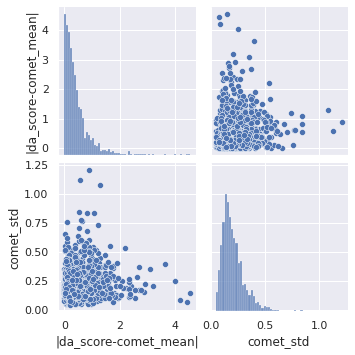

In [146]:
sns.pairplot(tmp_df[['|da_score-comet_mean|', 'comet_std']])


Text(0, 0.5, 'values')

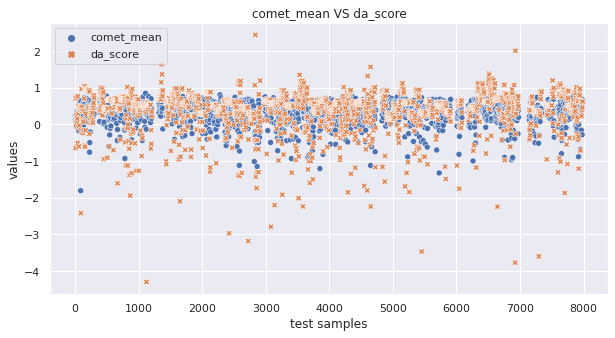

In [147]:
sns.scatterplot(data=tmp_df[['comet_mean', 'da_score']])
plt.title('comet_mean VS da_score')
plt.xlabel('test samples')
plt.ylabel('values')

Text(0, 0.5, 'values')

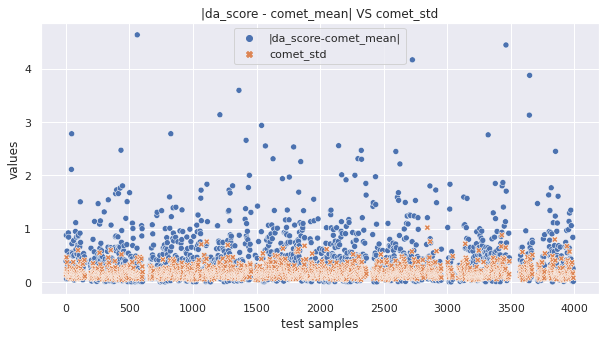

In [49]:
sns.scatterplot(data=tmp_df[['|da_score-comet_mean|', 'comet_std']])
plt.title('|da_score - comet_mean| VS comet_std')
plt.xlabel('test samples')
plt.ylabel('values')

## evaluation based on the log-likelihood metric  
log p(q | mu, sigma_sq) 


In [148]:
from scipy.stats import norm

In [149]:
eps = np.finfo(float).eps # to avoid -inf when computing np.log(0)
eps

2.220446049250313e-16

In [150]:
tmp = []
probs = []
for i, q in enumerate(z_scores):
    prob = norm.pdf(q, mean_vals[i], std_vals[i])
    probs.append(prob)
    tmp.append(np.log(prob+eps))

In [151]:
np.sum(np.log(probs+eps))

-7300.567082659469

In [152]:
round(np.sum(np.log(probs+eps))/len(probs), 6) #! the value we want to compare (want: as big as possible) 
# z_scores and not norm comet

-4.186105

In [99]:
# or as small as possible
np.abs(np.sum(np.log(probs+eps))/len(probs)) #! the value we want to compare 

4.632666848551917

In [153]:
from scipy.stats import norm
from scipy.stats import pearsonr

score_diff=[]
for zs, cs in zip(z_scores, mean_vals):
    score_diff.append(abs(zs - cs))
    
pearson_corr = pearsonr(score_diff, std_vals)
print(round(pearson_corr[0], 6))
pearson_corr

0.154481


(0.15448128403566008, 8.833755957418496e-11)

In [ ]:
# try norm.logpdf

In [147]:
norm.var(mean_vals[0],0.01)

0.0001

In [142]:
# var starting from 0.001 to 0.5, step 0.001
# find optomal std for a baseline

vals = []
for j in tqdm(np.arange(0.5, 0.8, 0.001)): 
    probs = []
    for i, q in enumerate(z_scores):
        prob = norm.pdf(q, mean_vals[i], j)
        probs.append(prob)
    vals.append(np.sum(np.log(probs+eps))/len(probs))

100%|██████████| 301/301 [00:53<00:00,  5.61it/s]


In [143]:
np.argmax(vals)

300

In [144]:
vals[np.argmax(vals)]

-1.6878358116439027

In [137]:
np.arange(0.001, 0.5, 0.001)[498]

0.499

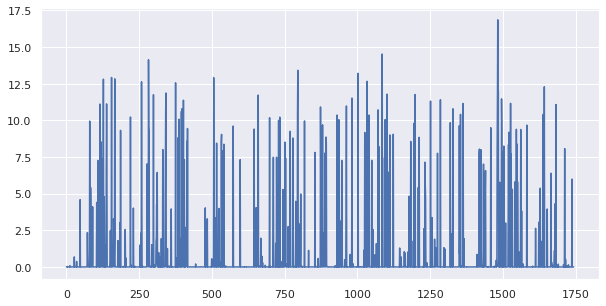

In [69]:
plt.plot(probs, color='b')

/media/hdd1/glushkovato/comet/py37_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


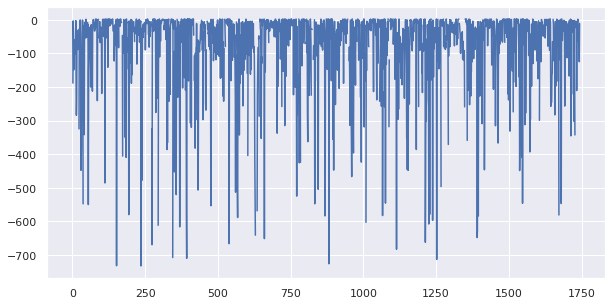

In [88]:
plt.plot(np.log(probs), color='b')

In [35]:
np.sum(tmp)

-37572.37062613824

In [74]:
np.log(norm.pdf(z_scores, mean, std))

array([  0.35527887, -10.78837592,  -2.41678263, ...,   0.38723281,
         0.18440155,   0.38723281])

In [72]:
np.log(norm.pdf(z_scores, mean, std)).sum()

-4415.865239777251

In [73]:
# np.log(norm.pdf(z_scores_norm, mean, std)).sum()

In [28]:
probs = norm.pdf(z_scores, mean, std)
probs

array([1.42657842e+00, 2.06380123e-05, 8.92081720e-02, ...,
       1.47289936e+00, 1.20249859e+00, 1.47289936e+00])

In [29]:
np.array(probs).any() >= 1

True

In [ ]:
probs

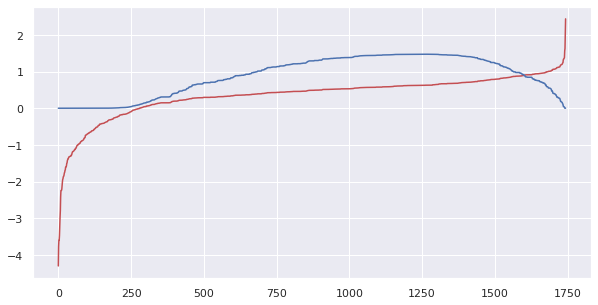

In [28]:
z_scores, probs = zip(*sorted(zip(z_scores, probs)))

plt.plot(z_scores, color='r')
plt.plot(probs, color='b')
# plt.plot(np.log(probs), color='g')
plt.show()

# positive-neutral-negative

		
DAs\comet	positive   neutral	negative       
positive	  <<	      >>	   >>      
neutral	      >>	      <<	   >>       
negative	  >>	      >>	   >>      



In [106]:
# comet_mean
# negative <= -1.5
# neutral >-1.5 and <1.5
# positive >=1.5

# da_score
# negative <= -1.5
# neutral >-1.5 and <1.5
# positive >=1.5

Freedman–Diaconis number of bins: 32


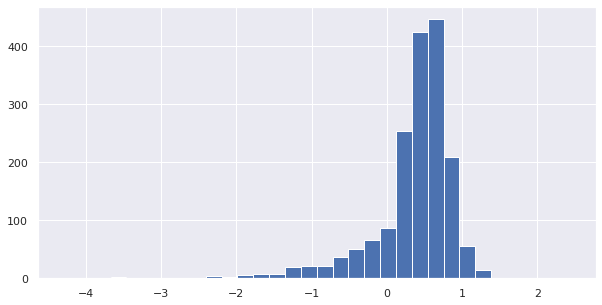

In [93]:
x = np.array(z_scores)
q25, q75 = np.percentile(x,[.25,.75])
bin_width = 2*(q75 - q25)*len(x)**(-1/3)
bins = round((x.max() - x.min())/bin_width)
print("Freedman–Diaconis number of bins:", bins)
plt.hist(x, bins = bins);

# plt.hist(z_scores)

In [104]:
len(x)

1744

In [101]:
((x<0)*1).sum()

280

In [105]:
((x>=0)*1).sum()

1464

Freedman–Diaconis number of bins: 61


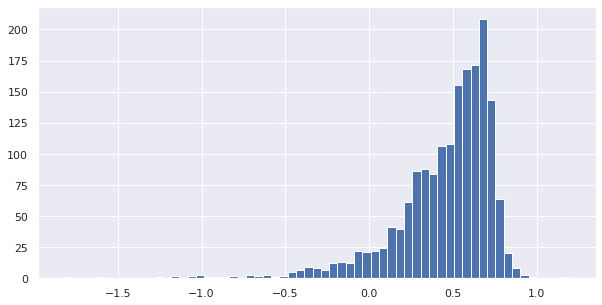

In [92]:
x = np.array(mean_vals)
q25, q75 = np.percentile(x,[.25,.75])
bin_width = 2*(q75 - q25)*len(x)**(-1/3)
bins = round((x.max() - x.min())/bin_width)
print("Freedman–Diaconis number of bins:", bins)
plt.hist(x, bins = bins);

# plt.hist(z_scores)

## t-test

7 and 9       
segments-lw-dropout-01.json     
segments-fulltrain-dropout-01.json     

11 and 16     
segments-fulltrain-90dpruns.json      
segments-ar-arp-wmtp-fulltrain.json

In [3]:
## Import the packages
import numpy as np
from scipy import stats
import json

In [73]:
# 7 and 9       
# segments-lw-dropout-01.json     
# segments-fulltrain-dropout-01.json    

f1 = open('/media/hdd1/glushkovato/comet/segments-lw-dropout-01.json', 'r')
f2 = open ('/media/hdd1/glushkovato/comet/segments-fulltrain-dropout-01.json', "r") 


data1 = json.loads(f1.read()) 
f1.close() 

data2 = json.loads(f2.read()) 
f2.close() 

In [74]:
lines = []
for i in data1:
    lines.append([i['src'], i['mt'], i['ref'], i['predicted_score_mean'], i['predicted_score_std']])
    
df1 = pd.DataFrame(data=np.array(lines), 
              columns=['src','mt', 'ref', 'predicted_score_mean','predicted_score_std'])

# df = df.iloc[::1, :]
# df1.iloc[:3]

In [75]:
lines = []
for i in data2:
    lines.append([i['src'], i['mt'], i['ref'], i['predicted_score_mean'], i['predicted_score_std']])
    
df2 = pd.DataFrame(data=np.array(lines), 
              columns=['src','mt', 'ref', 'predicted_score_mean','predicted_score_std'])

# df = df.iloc[::1, :]
# df2.iloc[:3]

In [76]:
a = np.array(df1.predicted_score_std.apply(pd.to_numeric, errors='coerce').tolist())
b = np.array(df2.predicted_score_std.apply(pd.to_numeric, errors='coerce').tolist())

We can use this test, if we observe two independent samples from the same or different population, e.g. exam scores of boys and girls or of two ethnic groups. The test measures whether the average (expected) value differs significantly across samples. 

If we observe a large p-value, for example larger than 0.05 or 0.1, then we cannot reject the null hypothesis of identical average scores. If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages.

In [77]:
## Cross Checking with the internal scipy function
t, p = stats.ttest_ind(a, b)
print("t = " + str(t))
print("p = " + str(p))

t = -6.216871760108584
p = 5.592234482107767e-10


In [78]:
p < 0.1

True

In [59]:
a.var()

0.002598976945724452

In [60]:
b.var()

0.002190845287664956

In [62]:
# 11 and 16     
# segments-fulltrain-90dpruns.json      
# segments-ar-arp-wmtp-fulltrain.json

f1 = open('/media/hdd1/glushkovato/comet/segments-fulltrain-90dpruns.json', 'r')
f2 = open('/media/hdd1/glushkovato/comet/segments-ar-arp-wmtp-fulltrain.json', 'r')

data1 = json.loads(f1.read()) 
f1.close() 

data2 = json.loads(f2.read()) 
f2.close() 

In [63]:
lines = []
for i in data1:
    lines.append([i['src'], i['mt'], i['ref'], i['predicted_score_mean'], i['predicted_score_std']])
    
df1 = pd.DataFrame(data=np.array(lines), 
              columns=['src','mt', 'ref', 'predicted_score_mean','predicted_score_std'])


lines = []
for i in data2:
    lines.append([i['src'], i['mt'], i['ref'], i['predicted_score_mean'], i['predicted_score_std']])
    
df2 = pd.DataFrame(data=np.array(lines), 
              columns=['src','mt', 'ref', 'predicted_score_mean','predicted_score_std'])

In [64]:
a = np.array(df1.predicted_score_std.apply(pd.to_numeric, errors='coerce').tolist())
b = np.array(df2.predicted_score_std.apply(pd.to_numeric, errors='coerce').tolist())

In [65]:
## Cross Checking with the internal scipy function
t, p = stats.ttest_ind(a, b, equal_var=False)
print("t = " + str(t))
print("p = " + str(p))

t = -59.86919612471615
p = 0.0


In [66]:
a.var()

0.0020971998514667176

In [67]:
b.var()

0.013622735865360409

1.0170239441069984
t = 2.801981914210512
p = 0.011786556548031069
t = 2.8019819142105113
p = 0.011786556548031204


In [37]:
N = 10
#Gaussian distributed data with mean = 2 and var = 1
a = np.random.randn(N) + 2
b = np.random.randn(N)

In [38]:
a.mean()

1.6802589204639933

In [39]:
#Gaussian distributed data with with mean = 0 and var = 1
b = np.random.randn(N)
b.mean()

0.4058420751884923

In [ ]:
## Define 2 random distributions
#Sample Size
N = 10
#Gaussian distributed data with mean = 2 and var = 1
a = np.random.randn(N) + 2
#Gaussian distributed data with with mean = 0 and var = 1
b = np.random.randn(N)


## Calculate the Standard Deviation
#Calculate the variance to get the standard deviation

#For unbiased max likelihood estimate we have to divide the var by N-1, and therefore the parameter ddof = 1
var_a = a.var(ddof=1)
var_b = b.var(ddof=1)

#std deviation
s = np.sqrt((var_a + var_b)/2)
s



## Calculate the t-statistics
t = (a.mean() - b.mean())/(s*np.sqrt(2/N))



## Compare with the critical t-value
#Degrees of freedom
df = 2*N - 2

#p-value after comparison with the t 
p = 1 - stats.t.cdf(t,df=df)


print("t = " + str(t))
print("p = " + str(2*p))
### You can see that after comparing the t statistic with the critical t value (computed internally) we get a good p value of 0.0005 and thus we reject the null hypothesis and thus it proves that the mean of the two distributions are different and statistically significant.


## Cross Checking with the internal scipy function
t2, p2 = stats.ttest_ind(a,b)
print("t = " + str(t2))
print("p = " + str(p2))